# XGBoost Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Load Split Data

In [2]:
clean_train = "../../data/clean/clean_train.csv"
clean_val = "../../data/clean/clean_val.csv"
clean_test = "../../data/clean/clean_test.csv"
train_subsam = "../../data/clean/train_subsam.csv"
train_smote = "../../data/clean/train_smote.csv"
xg_boost_model = "../../models/xgboost_model.joblib"

rnd_xgb = 44
num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [3]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

df_under = pd.read_csv(train_subsam, low_memory=False)
df_smote = pd.read_csv(train_smote, low_memory=False)

In [4]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])
X_under = df_under.drop(columns=target)
X_smote = df_smote.drop(columns=target)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_under = df_under[target]
y_smote = df_smote[target]

In [5]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

print(f"SubSam: {X_under.shape}, {y_under.shape}")
print(f"SMOTE:  {X_smote.shape}, {y_smote.shape}")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)

SubSam: (219654, 18), (219654,)
SMOTE:  (1033686, 18), (1033686,)


## Model Training

### Model Tuning

In [ ]:
param_grid = {"learning_rate": [0.1, 0.2, 0.3],
              "max_depth": [10, 20, 30],
              "n_estimators": [100, 200, 300],
              "random_state": [rnd_xgb]}

In [ ]:
grid_xgb = GridSearchCV(XGBClassifier(), param_grid, cv=10)
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [10, 20, 30],
                         'n_estimators': [100, 200, 300],
                         'random_state': [44]})

In [ ]:
params = grid_xgb.best_params_

print("Better Parameters:", params)

Better Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'random_state': 44}


In [ ]:
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=rnd_xgb)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [ ]:
acc_val = xgb_model.score(X_val, y_val)

print("Accuracy Val:", round(acc_val, 4))

Accuracy Val: 0.9547


### Feature Importance

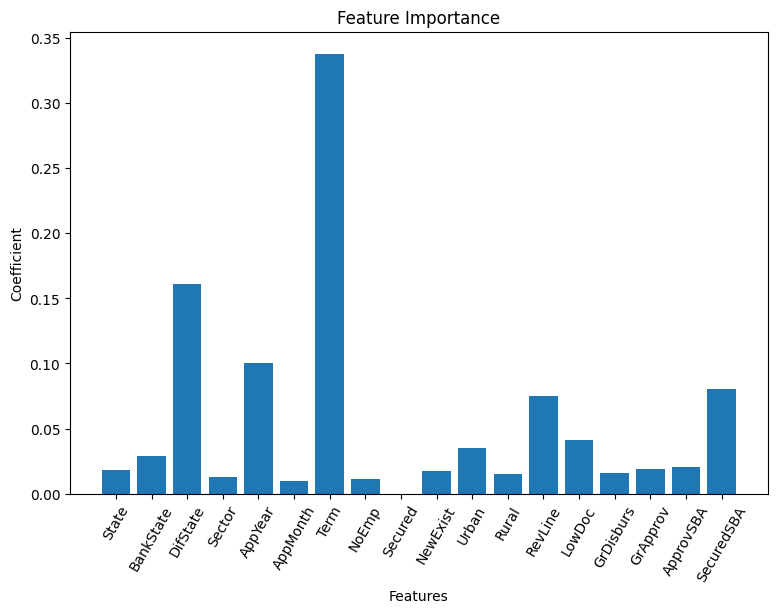

In [ ]:
X_cols = X_train.columns
fi_xgb = xgb_model.feature_importances_

plt.figure(figsize=(9, 6))
plt.bar(X_cols, fi_xgb)

plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.xticks(rotation=60)
plt.show()

### Recursive Feature Elimination

In [76]:
xgb_ref = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=rnd_xgb)

rfe_xgb = RFE(xgb_ref)
rfe_xgb.fit(X_train, y_train)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=0.1, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=10, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, multi_strategy=None,
                            n_estimators=300, n_jobs=None,
                            num_parallel_tree=None, random_state=44, ...))

In [77]:
rfe_mat = list(zip(X_train.columns.values.tolist(), rfe_xgb.support_, rfe_xgb.ranking_))
rfe_mat

[('State', False, 2),
 ('BankState', True, 1),
 ('DifState', True, 1),
 ('Sector', False, 7),
 ('AppYear', True, 1),
 ('AppMonth', False, 9),
 ('Term', True, 1),
 ('NoEmp', False, 8),
 ('Secured', False, 10),
 ('NewExist', False, 4),
 ('Urban', True, 1),
 ('Rural', False, 6),
 ('RevLine', True, 1),
 ('LowDoc', True, 1),
 ('GrDisburs', False, 5),
 ('GrApprov', False, 3),
 ('ApprovSBA', True, 1),
 ('SecuredSBA', True, 1)]

In [78]:
sel_cols = [tupla[1] for tupla in rfe_mat]
rfe_cols = X_train.loc[:, sel_cols].columns
rfe_cols

Index(['BankState', 'DifState', 'AppYear', 'Term', 'Urban', 'RevLine',
       'LowDoc', 'ApprovSBA', 'SecuredSBA'],
      dtype='object')

In [79]:
xgb_ref.fit(X_train[rfe_cols], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [80]:
y_ref = xgb_ref.predict(X_val[rfe_cols])
acc_ref = accuracy_score(y_val, y_ref)

print("Accuracy REF:", round(acc_ref, 4))

Accuracy REF: 0.9524


### Balanced Datasets

**Subsample Dataset**

In [81]:
xgb_under = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=rnd_xgb)

xgb_under.fit(X_under, y_under)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [82]:
acc_under = xgb_under.score(X_val, y_val)

print("Accuracy SubSampling:", round(acc_under, 4))

Accuracy SubSampling: 0.9214


**SMOTE Dataset**

In [83]:
xgb_smote = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=rnd_xgb)

xgb_smote.fit(X_smote, y_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [84]:
acc_smote = xgb_smote.score(X_val, y_val)

print("Accuracy SMOTE:", round(acc_smote, 4))

Accuracy SMOTE: 0.9276


## Model Evaluation

### Cross-Validation

**Testing the Model**

In [85]:
results = cross_val_score(xgb_model, X_test, y_test, cv=10)

print("Results:", results)
print("Accuracy Test (mean +/- desv): %0.4f +/- %0.4f" % (results.mean(), results.std()))

Results: [0.95263941 0.94914498 0.94951673 0.94832714 0.94884758 0.95063197
 0.95122677 0.94921933 0.95107443 0.95263588]
Accuracy Test (mean +/- desv): 0.9503 +/- 0.0015


In [86]:
y_cv_test = cross_val_predict(xgb_model, X_test, y_test, cv=10)
acc_cv_test = accuracy_score(y_test, y_cv_test)

print("Accuracy Test:", round(acc_cv_test, 4))

Accuracy Test: 0.9503


**Model Scores**

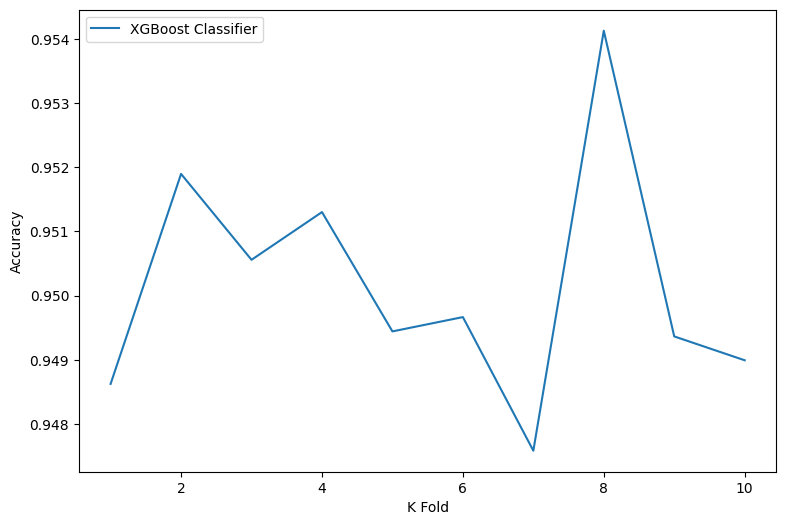

In [87]:
kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(xgb_model, X_test, y_test, cv=kf, scoring="accuracy")

plt.figure(figsize=(9, 6))
plt.plot(range(1, 11), scores, label="XGBoost Classifier")

plt.xlabel("K Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Classification Metrics

**Classification Report**

In [88]:
y_pred = xgb_model.predict(X_test)

In [89]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9542
Precisión:    0.9289
Sensibilidad: 0.9117
F1-score:     0.9200


In [90]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9671    0.9776    0.9723    110629
           1     0.8906    0.8459    0.8677     23869

    accuracy                         0.9542    134498
   macro avg     0.9289    0.9117    0.9200    134498
weighted avg     0.9535    0.9542    0.9537    134498



**Confusion Matrix**

In [91]:
cm_xgb = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_xgb)

[[0.80409374 0.01843894]
 [0.02734613 0.15012119]]


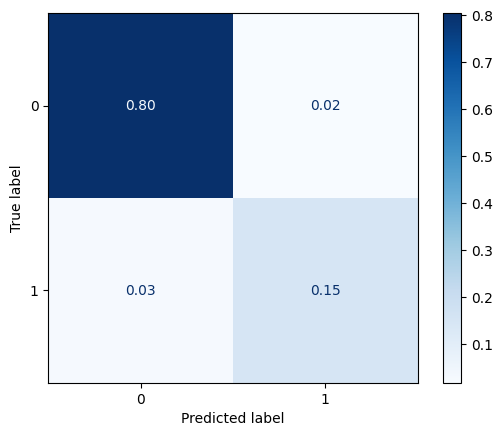

In [92]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                              display_labels=xgb_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

**ROC (Receiver Operating Characteristic) Curve**

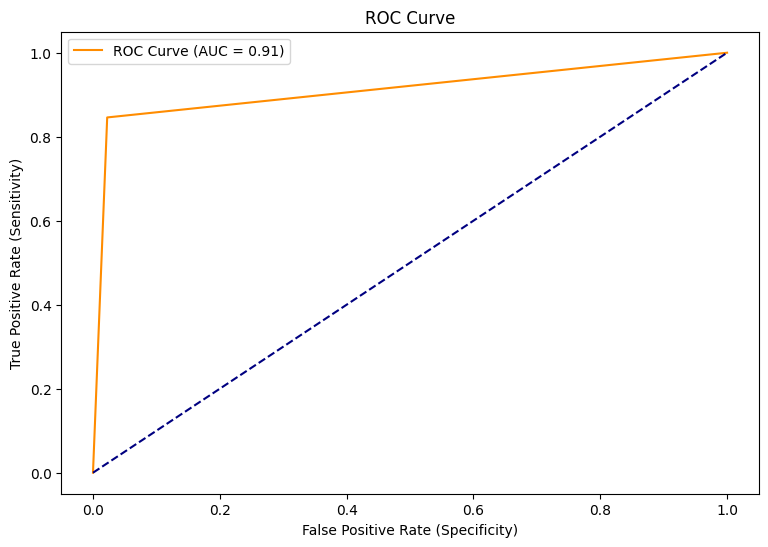

In [93]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

## Model Pipeline

### Create the Pipeline

In [94]:
class XGBoostModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.xgboost = XGBClassifier(learning_rate=0.1,
                                     max_depth=10,
                                     n_estimators=300,
                                     random_state=rnd_xgb)

    def fit(self, X, y):
        self.xgboost.fit(X, y)
        return self

    def predict(self, X, y=None):
        y_pred = self.xgboost.predict(X)
        return y_pred

In [95]:
xgboost_custom = Pipeline([
    ("custom_model", XGBoostModel())
    ])

### Test the Pipeline

**Internal Partition**

In [96]:
xgboost_custom.fit(X_train, y_train)

y_pred = xgboost_custom.predict(X_val)

In [97]:
print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.9547
Precisión:    0.9285
Sensibilidad: 0.9138
F1-score:     0.9209


**External Partition**

In [98]:
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

xgboost_custom.fit(X_train_val, y_train_val)

y_pred = xgboost_custom.predict(X_test)

In [99]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9550
Precisión:    0.9300
Sensibilidad: 0.9133
F1-score:     0.9214


**The Best Model**

In [100]:
xgboost_custom.fit(X_train_val, y_train_val)

y_pred = xgboost_custom.predict(X_test)

In [101]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9550
Precisión:    0.9300
Sensibilidad: 0.9133
F1-score:     0.9214


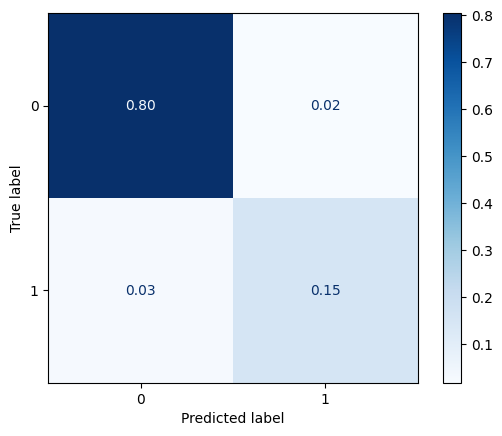

In [102]:
cm_xgb = confusion_matrix(y_test, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                              display_labels=xgb_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

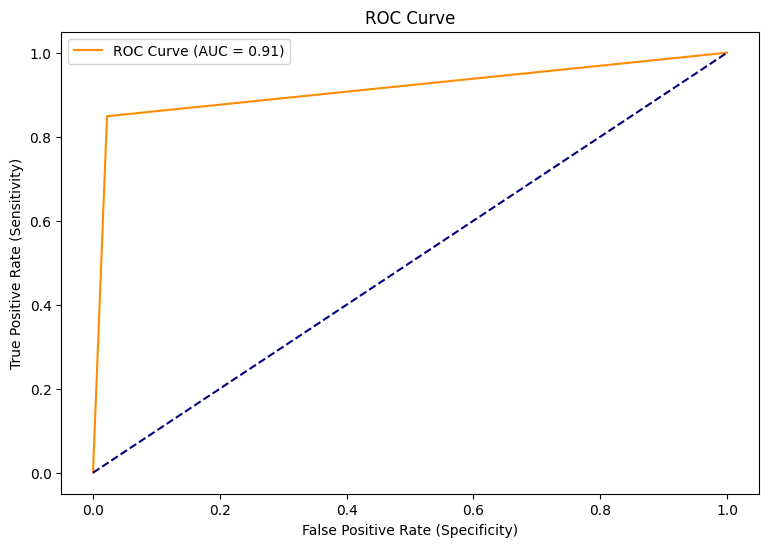

In [103]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

### Save the Model

In [104]:
try:
    joblib.dump(xgboost_custom, xg_boost_model)

    xgboost_model = joblib.load(xg_boost_model)
    print(f"XGBoost Classifier is loaded...")

except Exception as err:
    print("Error:", str(err))

XGBoost Classifier is loaded...


In [105]:
y_pred = xgboost_model.predict(X_test)
df_ = pd.concat([X_test, y_test, pd.DataFrame({"Pred": y_pred})], axis=1)

In [106]:
df_.sample(10)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,Pred
92735,31,49,1,4,40,11,84,5,0,0,1,0,1,0,114983,25000,12500,50,0,0
6976,30,33,0,16,37,6,84,1,0,0,1,0,1,0,33569,27000,13500,50,0,0
21956,22,25,0,20,32,5,60,5,0,0,0,0,0,0,95000,95000,76000,80,1,0
9581,8,41,1,12,33,5,60,1,0,1,0,0,0,0,39000,39000,31200,80,0,0
38643,14,11,1,7,41,6,84,6,0,0,1,0,1,0,25000,25000,12500,50,0,0
121921,44,48,0,13,31,9,240,1,1,0,0,0,0,0,426000,426000,426000,100,0,0
128929,47,38,1,0,41,1,18,4,0,0,1,0,1,0,90382,30000,15000,50,1,1
59245,14,17,0,16,35,1,240,40,1,0,0,0,0,0,750000,750000,750000,100,0,0
15267,2,3,0,16,43,2,120,6,0,0,1,0,0,0,215000,215000,161250,75,0,0
32491,13,45,1,7,25,11,300,1,1,0,0,0,0,0,72000,72000,64800,90,0,0
